# Shape

While the majority of `momepy` functions require the interaction of more `GeoDataFrames` or using spatial weights matrix, there are some which are calculated on single `GeoDataFrame` assessing the dimensions or shapes of features. This notebook illustrates how to measure simple shape characters.

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation.

In [2]:
import osmnx as ox

gdf = ox.geometries.geometries_from_place('Kahla, Germany', tags={'building':True})
buildings = ox.projection.project_gdf(gdf)

buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tess = momepy.Tessellation(buildings, unique_id='uID', limit=limit)
tessellation = tess.tessellation

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


/Users/martin/Git/geopandas/geopandas/geoseries.py:190: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)


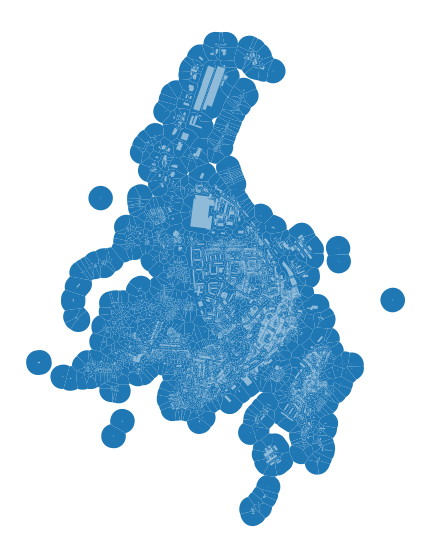

In [3]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

## Building shapes

Few examples of measuring building shapes. Circular compactness measures the ratio of object area to the area of its smallest circumsribed circle:

In [4]:
blg_cc = momepy.CircularCompactness(buildings)
buildings['circular_com'] = blg_cc.series

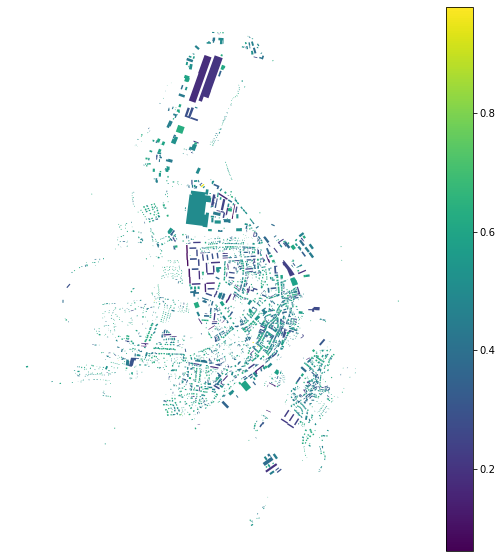

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='circular_com', legend=True, cmap='viridis')
ax.set_axis_off()
plt.show()

While elongation is seen as elongation of its minimum bounding rectangle:

In [6]:
blg_elongation = momepy.Elongation(buildings)
buildings['elongation'] = blg_elongation.series

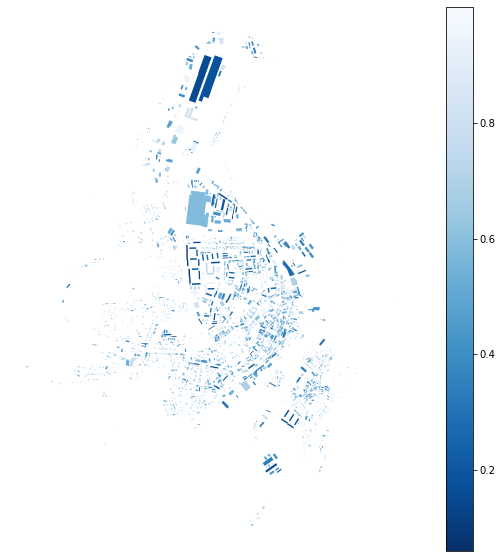

In [7]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='elongation', legend=True, cmap='Blues_r')
ax.set_axis_off()
plt.show()

And squareness measures mean deviation of all corners from 90 degrees: 

In [8]:
blg_squareness = momepy.Squareness(buildings)
buildings['squareness'] = blg_squareness.series

100%|█████████████████████████████████████| 2947/2947 [00:00<00:00, 3764.75it/s]


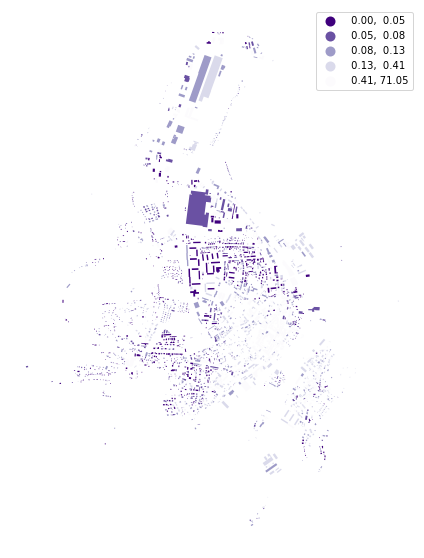

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='squareness', legend=True, scheme='quantiles', cmap='Purples_r')
ax.set_axis_off()
plt.show()

For the form factor, we need to know the volume of each building. While we do not have building height data for Kahla, we will generate them randomly and pass a `Series` containing volume values to `FormFactor`.

**Note**: For the majority of parameters you can pass values as the name of the column, `np.array`, `pd.Series` or any other list-like object.

In [10]:
blg_volume = momepy.Volume(buildings, np.random.randint(4, 20, size=len(buildings)))
buildings['formfactor'] = momepy.FormFactor(buildings, volumes=blg_volume.series).series

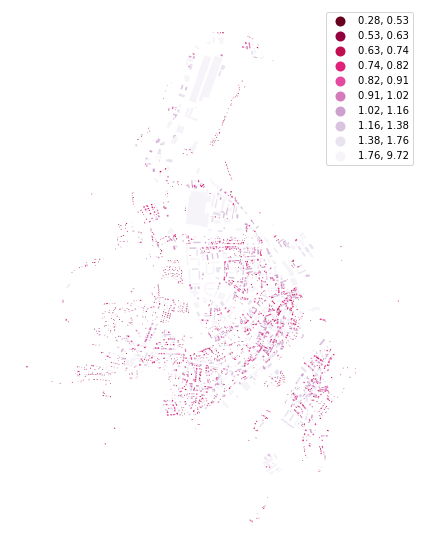

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='formfactor', legend=True, scheme='quantiles', k=10, cmap='PuRd_r')
ax.set_axis_off()
plt.show()

## Cell shapes

In theory, you can measure most of the 2D characters on all elements, including tessellation or blocks:

In [12]:
tes_cwa = momepy.CompactnessWeightedAxis(tessellation)
tessellation['cwa'] = tes_cwa.series

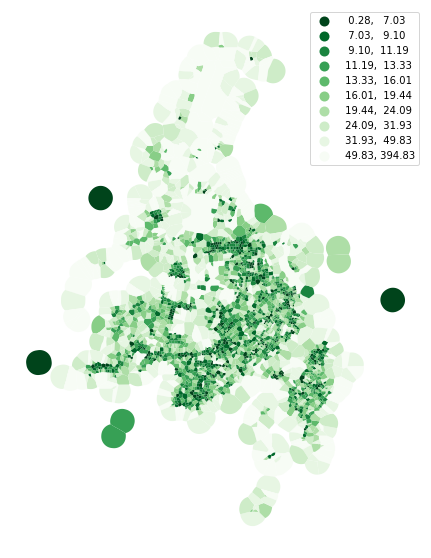

In [13]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='cwa', legend=True, scheme='quantiles', k=10, cmap='Greens_r')
ax.set_axis_off()
plt.show()

## Street network shapes

There are some characters which requires street network as an input. We can again use `osmnx` to retrieve it from OSM.

In [14]:
streets_graph = ox.graph_from_place('Kahla, Germany', network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)

`osmnx` returns networkx Graph. While momepy works with graph in some cases, for this one we need `GeoDataFrame`. To get it, we can use `ox.graph_to_gdfs`.

**Note**: `momepy.nx_to_gdf` might work as well, but OSM network needs to be complete in that case. `osmnx` takes care of it.

In [15]:
edges = ox.graph_to_gdfs(streets_graph, nodes=False, edges=True,
                                   node_geometry=False, fill_edge_geometry=True)

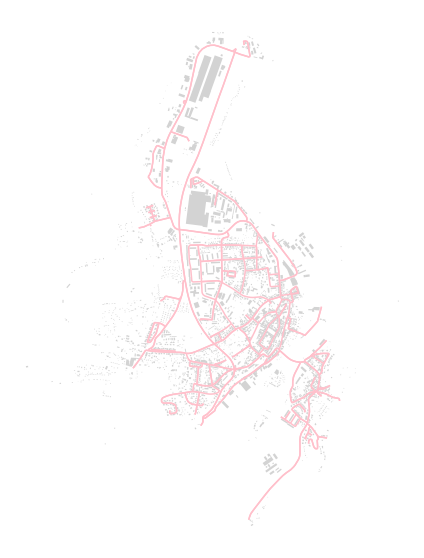

In [16]:
f, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, color='pink')
buildings.plot(ax=ax, color='lightgrey')
ax.set_axis_off()
plt.show()

Now we can calculate linearity of each segment:

In [17]:
edg_lin = momepy.Linearity(edges)
edges['linearity'] = edg_lin.series

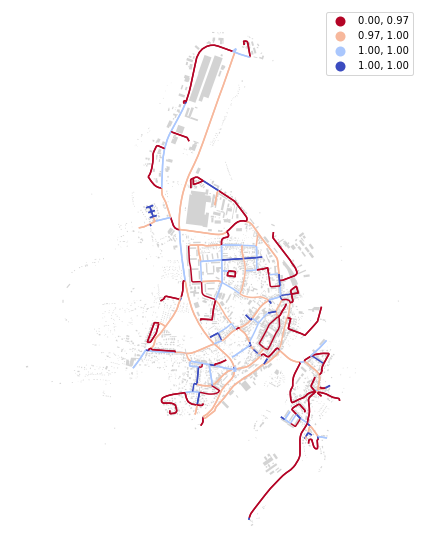

In [18]:
f, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, column='linearity', legend=True, cmap='coolwarm_r', scheme='quantiles', k=4)
buildings.plot(ax=ax, color='lightgrey')
ax.set_axis_off()
plt.show()